# Classifiers

This notebook explores a simple classification task.

Consider the following classification problem inspired by the analysis of this provocative video about how machine learning could change education (relevant to this problem at about the 32 minute mark):

https://www.youtube.com/watch?v=XSKfHDMXIgg

Briefly, the task is that you are given the (x,y) coordinates of the following colored points, and asked to match them to their respective color, or classification. For example, (0.1, 0.3) should be labeled "Blue".

<img src="classifier-problem.png" width="50%">

In [291]:
import conx as cx

First, we need the data. I displayed the picture and positioned my mouse over each point and recorded the (x,y) for each group.

Note: I changed "yellow" to "purple" in an attempt to make it stand out a bit more.

In [292]:
blue   = [( 90, 404), (143, 396), (231, 377), 
          (310, 342), (367, 276), (402, 188), 
          (391,  70)]
red    = [( 94, 196), (126,  78), (233, 269), 
          (232, 126), (307,  75), (633, 271)]
green  = [(230, 522), (330, 419), (476, 464), 
          (607, 165), (684, 509), (627,  45), 
          (720, 175)]
purple = [(542, 296), (504, 167), (500, 60), 
          (620, 400), (720, 437)]

size = (800, 600)

However, the mouse-over (x,y) was in the wrong coordinate system (origin was at the upper left-hand corner, and we prefer values closer to zero). So we can write a quick function to scale the values:

In [293]:
def scale(data, size):
    return [(x/size[0],1 - y/size[1]) for (x,y) in data]

In [294]:
scale(blue, size)

[(0.1125, 0.32666666666666666),
 (0.17875, 0.33999999999999997),
 (0.28875, 0.3716666666666667),
 (0.3875, 0.43000000000000005),
 (0.45875, 0.54),
 (0.5025, 0.6866666666666666),
 (0.48875, 0.8833333333333333)]

To check to see if this matches the image from the video, let's plot them. First we create a dictionary to map labels to color/shapes for the plot:

In [295]:
## "r" is red, "g" is green, "b" is blue, 
## "m" is magenta/purple, and "o" means plot a dot
symbols = {"Red": "ro", "Green": "go", "Blue": "bo", "Purple": "mo"}

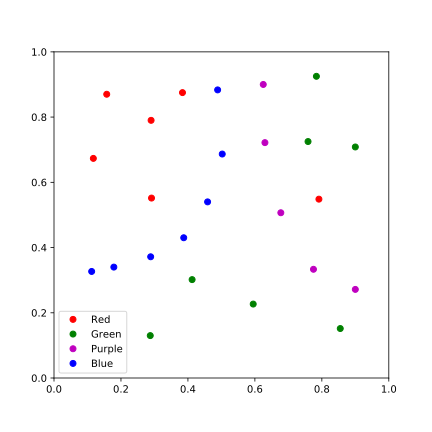

In [325]:
cx.scatter([["Red", scale(red, size)], 
            ["Green", scale(green, size)],
            ["Purple", scale(purple, size)],
            ["Blue", scale(blue, size)]], 
            symbols=symbols, 
            xmin=0, xmax=1,
            ymin=0, ymax=1)

Now we construct a network to learn the task. 

There are many way to design a network to do classification. In this example, we use a four-unit output layer (one for each classification) and the "softmax" activation function. We want to use the "categorical_crossentropy" error function to match the "softmax" activations. 

Note: it took about a dozen variations before we found a network that could learn this task. Things to try changing:

* optimizer
* learning rate and momentum for "sgd" optimizer
* hidden layer size
* hidden layer activation function

Also, when training, variations to try:

* batch_size

Eventually, we find a combination that can learn. There are probably many different combinations that will work. Understanding how the different combinations of meta-parameters effect learning takes some time, experience, and understanding.

In [305]:
net = cx.Network("RGB Classifier")
net.add(cx.Layer("input", 2),
        cx.Layer("hidden", 10, activation="relu"),
        cx.Layer("output", 4, activation="softmax"))
net.connect()
net.compile(error="categorical_crossentropy", 
            optimizer="sgd", lr=0.1, momentum=0.3)

<IPython.core.display.Javascript object>


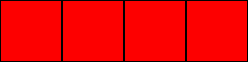
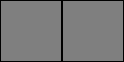

In [306]:
net.picture()

Now we construct the data for the dataset. We use the cx.onehot() function to assign each label a unique output target.

In [307]:
ds = ([(inputs, cx.onehot(0, 4), "Red") for inputs in scale(red, size)] +
      [(inputs, cx.onehot(1, 4), "Green") for inputs in scale(green, size)] +
      [(inputs, cx.onehot(3, 4), "Purple") for inputs in scale(purple, size)] +
      [(inputs, cx.onehot(2, 4), "Blue") for inputs in scale(blue, size)])

In [308]:
ds

[((0.1175, 0.6733333333333333), [1, 0, 0, 0], 'Red'),
 ((0.1575, 0.87), [1, 0, 0, 0], 'Red'),
 ((0.29125, 0.5516666666666667), [1, 0, 0, 0], 'Red'),
 ((0.29, 0.79), [1, 0, 0, 0], 'Red'),
 ((0.38375, 0.875), [1, 0, 0, 0], 'Red'),
 ((0.79125, 0.5483333333333333), [1, 0, 0, 0], 'Red'),
 ((0.2875, 0.13), [0, 1, 0, 0], 'Green'),
 ((0.4125, 0.30166666666666664), [0, 1, 0, 0], 'Green'),
 ((0.595, 0.22666666666666668), [0, 1, 0, 0], 'Green'),
 ((0.75875, 0.725), [0, 1, 0, 0], 'Green'),
 ((0.855, 0.15166666666666662), [0, 1, 0, 0], 'Green'),
 ((0.78375, 0.925), [0, 1, 0, 0], 'Green'),
 ((0.9, 0.7083333333333333), [0, 1, 0, 0], 'Green'),
 ((0.6775, 0.5066666666666666), [0, 0, 0, 1], 'Purple'),
 ((0.63, 0.7216666666666667), [0, 0, 0, 1], 'Purple'),
 ((0.625, 0.9), [0, 0, 0, 1], 'Purple'),
 ((0.775, 0.33333333333333337), [0, 0, 0, 1], 'Purple'),
 ((0.9, 0.2716666666666666), [0, 0, 0, 1], 'Purple'),
 ((0.1125, 0.32666666666666666), [0, 0, 1, 0], 'Blue'),
 ((0.17875, 0.33999999999999997), [0, 0, 1, 

In [309]:
net.dataset.load(ds)

In [310]:
net.dataset.inputs[0], net.dataset.targets[0], net.dataset.labels[0]

([0.11749999970197678, 0.6733333468437195], [1.0, 0.0, 0.0, 0.0], 'Red')

We use a testing trick: we assign the entire set to be used as validation, and set the use_validation_to_stop criteria to be True. We do this because the accuracy of each pattern is normally computed after each batch, rather than at the end of the epoch (for efficiency). Using use_validation_to_stop=True will use the true accuracy to make sure that we get them all 100% correct.

In [311]:
net.dataset.split("all")

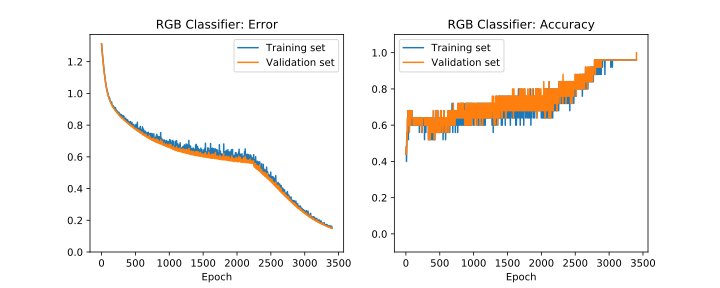

       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
# 3404 |   0.15078 |   0.96000 |   0.14923 |   1.00000 
Saving network... Saved!


In [346]:
net.reset()
net.train(15000, accuracy=1.0, batch_size=16, 
          report_rate=200, use_validation_to_stop=True,
          save=True, record=50)

In [347]:
net.test(show=True, tolerance=0.5)

Testing validation dataset with tolerance 0.5...
# | inputs | targets | outputs | result
---------------------------------------
0 | [[0.12,0.67]] | [[1.00,0.00,0.00,0.00]] | [1.00,0.00,0.00,0.00] | correct
1 | [[0.16,0.87]] | [[1.00,0.00,0.00,0.00]] | [1.00,0.00,0.00,0.00] | correct
2 | [[0.29,0.55]] | [[1.00,0.00,0.00,0.00]] | [0.88,0.00,0.12,0.00] | correct
3 | [[0.29,0.79]] | [[1.00,0.00,0.00,0.00]] | [1.00,0.00,0.00,0.00] | correct
4 | [[0.38,0.88]] | [[1.00,0.00,0.00,0.00]] | [0.93,0.00,0.07,0.00] | correct
5 | [[0.79,0.55]] | [[1.00,0.00,0.00,0.00]] | [0.43,0.14,0.00,0.43] | X
6 | [[0.29,0.13]] | [[0.00,1.00,0.00,0.00]] | [0.00,1.00,0.00,0.00] | correct
7 | [[0.41,0.30]] | [[0.00,1.00,0.00,0.00]] | [0.00,0.88,0.11,0.01] | correct
8 | [[0.60,0.23]] | [[0.00,1.00,0.00,0.00]] | [0.00,0.97,0.00,0.03] | correct
9 | [[0.76,0.73]] | [[0.00,1.00,0.00,0.00]] | [0.02,0.96,0.00,0.03] | correct
10 | [[0.86,0.15]] | [[0.00,1.00,0.00,0.00]] | [0.00,0.96,0.00,0.04] | correct
11 | [[0.78,0.93]]

In [348]:
net.dashboard()

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, options=('Test', 'Train'), rows=1, value='Train'), FloatSlider(value=0.5, continuous_update=False, description='Zoom', layout=Layout(width='65%'), max=1.0, style=SliderStyle(description_width='initial')), IntText(value=150, description='Horizontal space between banks:', style=DescriptionStyle(description_width='initial')), IntText(value=30, description='Vertical space between layers:', style=DescriptionStyle(description_width='initial')), HBox(children=(Checkbox(value=False, description='Show Targets', style=DescriptionStyle(description_width='initial')), Checkbox(value=False, description='Errors', style=DescriptionStyle(description_width='initial')))), Select(description='Features:', options=('',), rows=1, value=''), IntText(value=3, description='Feature columns:', style=DescriptionStyle(description_width='initial')), FloatText(value=1.0, description='Feature scale:', style=DescriptionStyle(description_width='initial'))), layout=Layout(width='100%')), VBox(children=(Select(description='Layer:', index=2, options=('input', 'hidden', 'output'), rows=1, value='output'), Checkbox(value=True, description='Visible'), Select(description='Colormap:', options=('', 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Vega10', 'Vega10_r', 'Vega20', 'Vega20_r', 'Vega20b', 'Vega20b_r', 'Vega20c', 'Vega20c_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spectral', 'spectral_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'viridis', 'viridis_r', 'winter', 'winter_r'), rows=1, value=''), HTML(value='<img src="data:image/gif;base64,R0lGODdhLAEZAIcAAPIBAY8AAK8AANAAAAIC8wAAbwAAsAAAkAAA0Pr2+vPn8wAAVkdH/7a2///X1yYm/2Zm/3h4/5aW/9fX//8VFf8mJv84OP9WVv9nZ/+Ghv+YmP+2thYW/zU1/1hY/4aG/6Wl/8jI//9GRv92dv+mpv/FxX8AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA

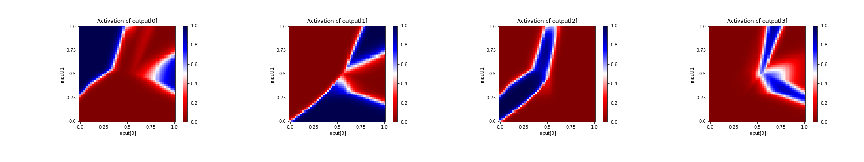

In [349]:
cx.view([net.plot_activation_map(to_unit=i, format="image") for i in range(4)], scale=3)

In [350]:
def function(x, y):
    output = net.propagate([x, y])
    if cx.argmax(output) == 0: ## red
        return 0.5
    elif cx.argmax(output) == 1: ## green
        return 1.0
    elif cx.argmax(output) == 2: ## blue
        return 0.0
    else:
        return 0.2
heatmap_image = cx.heatmap(function, colormap="brg", format="image")

In [351]:
scatter_image = cx.scatter([["Red", scale(red, size)], 
            ["Green", scale(green, size)],
            ["Purple", scale(purple, size)],
            ["Blue", scale(blue, size)]], 
            symbols=symbols, 
            xmin=0, xmax=1,
            ymin=0, ymax=1, format="image")

In [352]:
scatter_image.size

(432, 432)

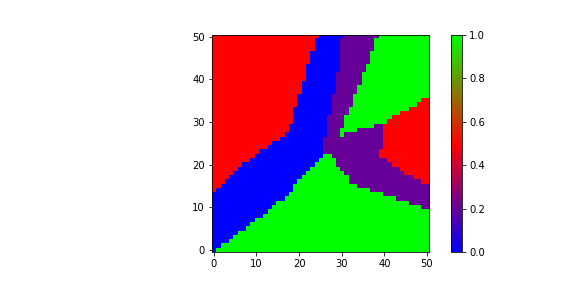

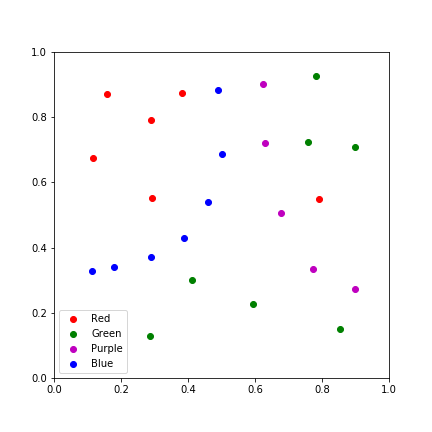

In [353]:
display(heatmap_image)
display(scatter_image)

SequenceViewer(children=(VBox(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description='RGB Classifier Playback:', layout=Layout(width='100%'), max=69, style=SliderStyle(description_width='initial')), Label(value='of 70', layout=Layout(width='100px'))), layout=Layout(height='40px')), HBox(children=(Button(icon='fast-backward', layout=Layout(width='100%'), style=ButtonStyle()), Button(icon='backward', layout=Layout(width='100%'), style=ButtonStyle()), IntText(value=0, layout=Layout(width='100%')), Button(icon='forward', layout=Layout(width='100%'), style=ButtonStyle()), Button(icon='fast-forward', layout=Layout(width='100%'), style=ButtonStyle()), Button(description='Play', icon='play', layout=Layout(width='100%'), style=ButtonStyle())), layout=Layout(height='50px', width='100%'))), layout=Layout(width='100%')), Output()))

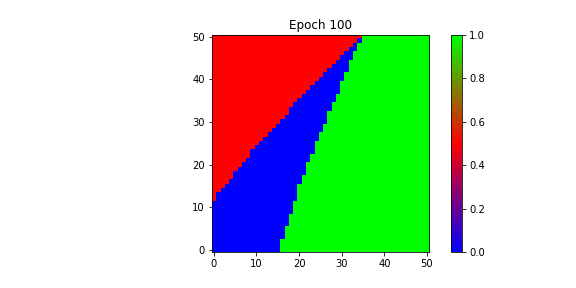

In [354]:
net.playback(lambda net, epoch: cx.heatmap(function, colormap="brg", title="Epoch %s" % epoch, format="image"))

In [355]:
net.movie(lambda net, epoch: cx.heatmap(function, colormap="brg", title="Epoch %s" % epoch, format="image"))